In [17]:
import pandas as pd
import time
import matplotlib.pyplot as plt

from lenskit.algorithms.implicit import ALS
from lenskit import batch, topn, util
from lenskit.algorithms import Recommender

## Import Entire Dataset

In [2]:
df_train = pd.read_parquet('processed_data/cf_train_idx.parquet')
df_val = pd.read_parquet('processed_data/cf_validation_idx.parquet')
df_test = pd.read_parquet('processed_data/cf_test_idx.parquet')

In [3]:
df_train.columns = ['user','count','item']
df_val.columns = ['user','count','item']
df_test.columns = ['user','count','item']

In [4]:
for i in ['user','count','item']:
    df_train[i] = df_train[i].astype(int)
    df_val[i] = df_val[i].astype(int)
    df_test[i] = df_test[i].astype(int)

## Downsample Training Data

First, we get all the unique users that exist in both validation and test data, then for each unique user, sample a few data points from the train data.

In [5]:
train = set(df_train['user'].unique().tolist())
val = set(df_val['user'].unique().tolist())
test = set(df_test['user'].unique().tolist())
users = val.union(test)

### Sub-sampling 1%

In [6]:
df_train_subset = df_train.sample(frac=0.01, replace=False, random_state=1)

## Train and Evaluate Implicit ALS

In [7]:
# set alpha since implicit does not support alpha parameter
alpha = 40
df_train_subset['count'] = alpha*df_train_subset['count']

In [8]:
def evaluate(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 500)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [9]:
model = ALS(factors=15, regularization=0.1)

In [10]:
all_recs = evaluate('ALS', model, df_train_subset, df_val)

In [11]:
all_recs.head()

,item,user,rank,score,Algorithm
0,16.0,565257,1,0.000056,ALS
1,12.0,565257,2,0.000020,ALS
2,11.0,565257,3,0.000019,ALS
3,10.0,565257,4,0.000017,ALS
4,14.0,565257,5,0.000015,ALS


In [12]:
rla = topn.RecListAnalysis()
# rla.add_metric(topn.ndcg)
rla.add_metric(topn.precision)
results = rla.compute(all_recs, df_val)
results['precision'].mean()

0.004011522633744856

## Putting All This Together

In [13]:
sub_sample = [0.01, 0.05, 0.25, 0.5, 1.0]
maps = []
elapsed_time = []

rla = topn.RecListAnalysis()
# rla.add_metric(topn.ndcg)
rla.add_metric(topn.precision)

for i in sub_sample:
    print('Running with {} % of sample'.format(i))
    start = time.time()
    df_train_subset = df_train.sample(frac=i, replace=False, random_state=1)

    model = ALS(factors=15, regularization=0.1)
    recs = evaluate('ALS', model, df_train_subset, df_test)
    
    results = rla.compute(recs, df_test)
    maps.append(results['precision'].mean())
    end = time.time()
    elapsed_time.append(int(end - start))

Running with 0.01 % of sample



Running with 0.05 % of sample



Running with 0.25 % of sample



Running with 0.5 % of sample



Running with 1.0 % of sample


## Comparison to Spark

In [31]:
df_sm = pd.DataFrame()
df_sm['map'] = maps
df_sm['time'] = elapsed_time
df_sm['size'] = sub_sample
df_sm.to_csv('sm_test_metrics.csv')

In [19]:
df_spark = pd.read_csv('spark_test_metrics.csv')
sp_elapsed_time = df_spark['time'].tolist()
sp_map = df_spark['map'].tolist()

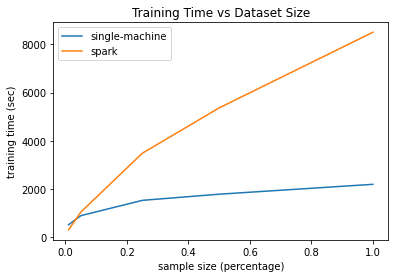

<Figure size 432x288 with 0 Axes>

In [28]:
plt.plot(sub_sample, elapsed_time, label='single-machine')
plt.plot(sub_sample, sp_elapsed_time, label='spark')
plt.title('Training Time vs Dataset Size')
plt.xlabel('sample size (percentage)')
plt.ylabel('training time (sec)')
plt.legend()
plt.show()
plt.savefig('time.png')

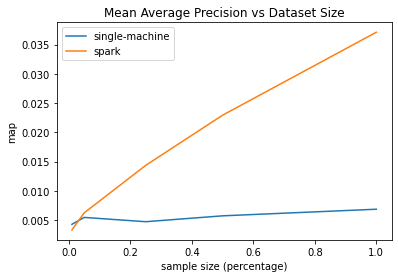

<Figure size 432x288 with 0 Axes>

In [27]:
plt.plot(sub_sample, maps, label='single-machine')
plt.plot(sub_sample, sp_map, label='spark')
plt.title('Mean Average Precision vs Dataset Size')
plt.xlabel('sample size (percentage)')
plt.ylabel('map')
plt.legend()
plt.show()
plt.savefig('map.png')